In [1]:
import sys
sys.path.append('/workspace')

import torch
import torch.nn.functional as F
import torch.optim as optim


# Import Dataset_Manager
from Data import CallDataSet
# Import File_Manager
from ModelFileManagement.MNIST_FileManage import MNISTFileManagement
from ModelFileManagement.MedMNIST_FileManage import MedMNISTFileManagement
from ModelFileManagement.FashionMNIST_FileManage import FashionMNISTFileManagement
# Impoer Atk_Module
import MakeAtkData
import Atk_Train

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import os
from pathlib import Path

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameter
target_data = "MNIST"
data_flag = 'organamnist'  # If target_data == MedMNIST, is used 
batch_size = 1000  # One Query == batch_size
Fractal = False  # Switch target_data to Fractal
FracName = "Frac60"
edit_data = [100]  # IF len(edit_data) == 2: num_classes = edit_data[0], num_samples = edit_data[1]を定義

# Access parameter
num_queries = 100  # クエリ回数
substitute_model_epochs = 30  # 代替モデルの訓練Epoch数
substitute_model_batch_size = 150  # 代替モデルの訓練batch数
lr = 0.001  # 代替モデルの訓練学習率
amsgrad=True  # 代替モデルAdamで使う
lr_sched = True  # 代替モデルの訓練学習率低減に使う



In [3]:
# Data import
D_import = CallDataSet.DataLoad(target_data, batch_size, data_flag, Fractal, FracName, edit_data)
train_loader, test_loader = D_import.import_data()

Dataset MNIST
    Number of datapoints: 60000
    Root location: /workspace/Data/MNIST_dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=nearest, max_size=None, antialias=None)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /workspace/Data/MNIST_dataset/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=nearest, max_size=None, antialias=None)
           )


In [4]:
# train_loader = D_import.second_import("MNIST")

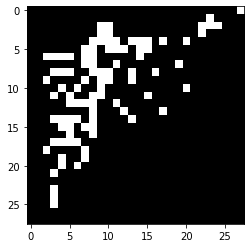

In [5]:
# Check data for attack
to_pil_image = transforms.ToPILImage()
for id ,data in enumerate(train_loader):
    pic, label = data[0],data[1]
    img_tensor = pic[0]

    img = to_pil_image(img_tensor)
    plt.imshow(img, cmap='gray')
    plt.show
    break

In [6]:
# ディレクトリの作成 :  Pathlib推奨
checkpoints_path_student = 'checkpoints_student/'
if not os.path.exists(checkpoints_path_student):
    os.makedirs(checkpoints_path_student)

base_dir = "/workspace/attacker_train/checkpoints_student/"
attack_dir = os.path.join(base_dir, target_data)
os.makedirs(attack_dir, exist_ok=True)

モデル呼び出し

In [7]:
#target_file_name
file_name = f"AttackerNetworkSmall_MNIST_epoch_30_data_MNIST"
model_size = "M"
if target_data == "MedMNIST":
    channels = D_import.n_channels
    classes = D_import.n_classes
    FileManager = MedMNISTFileManagement(file_name, model_size, channels, classes, data_flag)
elif target_data == "MNIST":
    FileManager = MNISTFileManagement(file_name, model_size)
elif target_data == "FashionMNIST":
    FileManager = FashionMNISTFileManagement(file_name, model_size)

In [8]:
target_net, load_path= FileManager.load_targetmodel()
student_net = FileManager.get_studentmodel()

ターゲットモデルにクエリする


In [15]:
#ターゲットモデルアクセス
def query_to_cloudmodel(target_net, query_data):
    query_data = query_data.to('cuda')  #Attaching at target_net
    with torch.no_grad():
        target_response = F.softmax(target_net(query_data), dim=1)
    target_response = target_response.to('cpu')  #Moving to cpu
    return target_response

学習タスク

In [16]:
#  テスト精度測定
test_acc = []
def pre_accuracy(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            if target_data == "MedMNIST":
                labels = labels.squeeze().long()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    substitute_mid_accuracy = (correct_predictions / total_predictions) * 100

    # Saving test_acc for plot
    test_acc.append(substitute_mid_accuracy)
    return substitute_mid_accuracy

In [17]:
# Making AtkDataset instance
AtkData_inst = MakeAtkData.AtkDataSet(substitute_model_batch_size, test_loader)
Atk_training = Atk_Train.AtkLeaning(target_data, test_loader, student_net, lr, amsgrad)

# 学習率減衰
lr_scheduler = optim.lr_scheduler.StepLR(Atk_training.optimizer, step_size= 10, gamma= 0.5)

# Attack
for query_idx, query_batch in enumerate(train_loader):
    if query_idx >= num_queries:
        print('[MESSAGE] # queries reaches query limit')
        break
    
    # Query to victim model
    query, _ = query_batch
    response = query_to_cloudmodel(target_net, query)
    # Add query and response to attack dataset
    AtkData_inst.add_query(query, response)

    # Train substitute model
    substitute_model_training_data = AtkData_inst.load_atk_dataset()
    substitute_model_training_data = substitute_model_training_data
    
    
    for epoch in range(substitute_model_epochs):
        for batch_idx, batch in enumerate(substitute_model_training_data):
            loss = Atk_training.attacker_training(batch)
    # Validation loop
        val_accuracy = Atk_training.getting_acc()
        
    Atk_training.load_best_model()

    if lr_sched == True:
        lr_scheduler.step()
    
    # if query_idx % 10 == 0:
    
    # Getting test_acc（テスト用データ使用）
    sub_accuracy = pre_accuracy(Atk_training.student_net, test_loader)
    print('query_idx: %d validation loss: %.3f validation accuracy: %.3f' %(query_idx, loss, sub_accuracy))

KeyboardInterrupt: 








ターゲットモデル：テスト精度


In [ ]:
checkpoint = torch.load(load_path)

# Load and print the accuracy and the epoch number
accuracy = checkpoint['results']
epoch = checkpoint['epoch']

print(f'Accuracy: {accuracy}, Epoch: {epoch}')

Accuracy: 98.1, Epoch: 30


テスト精度評価プロット


NameError: name 'test_acc' is not defined

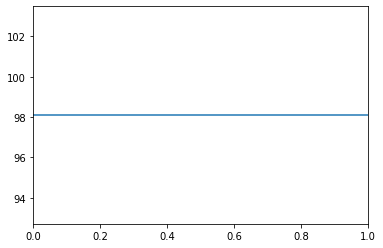

In [ ]:
# print('Fractal:',Fractal,':',target_data,':substitute_accuracy:%.3f' %(test_acc[37 -1]))
epochs_labels = [str(e)+'k' for e in range(num_queries)] 
# Plotting the training and validation accuracy
plt.axhline(accuracy, label='Target_acc')
plt.plot(test_acc, color = 'green', label='Attack_acc')
plt.xticks(range(num_queries),epochs_labels)
plt.xlabel('Querys')
plt.ylabel('Accuracy')
plt.ylim(0,100)
plt.legend()
plt.show()

Save substitute_model

In [14]:
FileManager.set_save_substitute_model(num_queries, test_acc, student_net, batch_size, substitute_model_epochs, substitute_model_batch_size, lr, FracName, Fractal)

NameError: name 'test_acc' is not defined

In [50]:
model_size = ["Fashion","Frac1k","Frac60","MNIST"]
model_paths = []
for size in model_size:
    path = Path("/workspace/attacker_train/checkpoints_student/FashionMNIST")
    minipath = "size_L_query_57_Batch_1000_FashionMNIST"
    fullpath = path/size/minipath
    print(fullpath)
    model_paths.append(fullpath)

/workspace/attacker_train/checkpoints_student/FashionMNIST/Fashion/size_L_query_57_Batch_1000_FashionMNIST
/workspace/attacker_train/checkpoints_student/FashionMNIST/Frac1k/size_L_query_57_Batch_1000_FashionMNIST
/workspace/attacker_train/checkpoints_student/FashionMNIST/Frac60/size_L_query_57_Batch_1000_FashionMNIST
/workspace/attacker_train/checkpoints_student/FashionMNIST/MNIST/size_L_query_57_Batch_1000_FashionMNIST


In [51]:
def load_model_results(path_list):
    results = []
    for path in path_list:
        checkpoint = torch.load(path)
        results.append(checkpoint['results'])
    return results

In [52]:
results = load_model_results(model_paths)

for i, result in enumerate(results):

    print(f"Results for model {i+1}: {result}")

Results for model 1: [78.8, 84.42, 85.87, 86.5, 87.09, 86.92999999999999, 87.22999999999999, 87.03, 87.3, 87.25, 87.35000000000001, 87.29, 87.21, 87.27000000000001, 87.22999999999999, 87.44, 87.19, 87.31, 87.2, 87.3, 87.22, 87.27000000000001, 87.3, 87.16000000000001, 87.45, 87.31, 87.46000000000001, 87.36, 87.33999999999999, 87.36, 87.21, 87.19, 87.39, 87.35000000000001, 87.42999999999999, 87.42999999999999, 87.44, 87.46000000000001, 87.48, 87.49, 87.42999999999999, 87.5, 87.49, 87.52, 87.68, 87.53, 87.41, 87.42, 87.62, 87.48, 87.55, 87.63, 87.41, 87.53, 87.52, 87.52, 87.58]
Results for model 2: [32.75, 46.51, 50.260000000000005, 58.3, 64.2, 67.2, 67.99, 69.58, 70.95, 73.22999999999999, 75.37, 75.76, 75.91, 76.21, 76.96, 78.4, 77.48, 76.67, 78.59, 74.98, 76.92, 80.21000000000001, 80.42, 80.87, 79.96, 80.28999999999999, 80.11, 81.11, 81.87, 81.16, 80.31, 81.75, 81.16, 81.82000000000001, 81.41000000000001, 82.39, 81.8, 82.34, 82.69999999999999, 82.01, 81.58999999999999, 82.67999999999999

In [53]:
results = load_model_results(model_paths)

for i, result in enumerate(results):

    print(f"Results for model {i+1}: {result[-1]}")

Results for model 1: 87.58
Results for model 2: 82.69
Results for model 3: 81.14
Results for model 4: 63.94


In [54]:
results = load_model_results(model_paths)

for i, result in enumerate(results):

    print(f"Results for model {i+1}: {result[-1]}")

Results for model 1: 87.58
Results for model 2: 82.69
Results for model 3: 81.14
Results for model 4: 63.94


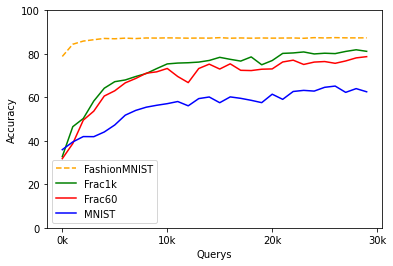

In [55]:
import numpy as np
plt.plot(results[0][:30], color = 'orange', label="FashionMNIST", linestyle='--')
plt.plot(results[1][:30], color = 'green', label=model_size[1])
plt.plot(results[2][:30], color = 'red', label=model_size[2])
plt.plot(results[3][:30], color = 'blue', label=model_size[3])
# x軸の目盛りを設定
x_ticks = np.arange(0, 31, 10)  # 0から50まで10の刻みでx軸の目盛りを設定
# x軸のラベルを文字列に変換し、'k'を追加
x_labels = [str(x) + 'k' for x in x_ticks]
plt.xticks(x_ticks, x_labels) 

plt.xlabel('Querys')
plt.ylabel('Accuracy')
plt.ylim(0,100)
plt.legend()
plt.show()

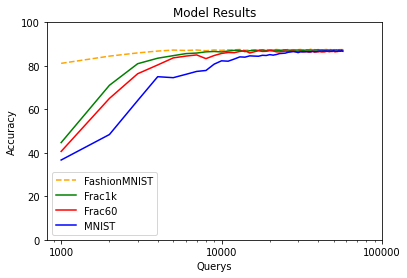

In [49]:
import numpy as np

# 対数軸に設定
plt.xscale("log")
# x軸の値を作成します。
x_values = [i for i in range(1, max(len(results[0]), len(results[1]), len(results[2]), len(results[3])) + 1)]


plt.plot(x_values[:len(results[0])], results[0], color = 'orange', label="FashionMNIST", linestyle='--')
plt.plot(x_values[:len(results[1])], results[1], color = 'green', label=model_size[1])
plt.plot(x_values[:len(results[2])], results[2], color = 'red', label=model_size[2])
plt.plot(x_values[:len(results[3])], results[3], color = 'blue', label=model_size[3])

# グラフにタイトルを設定します。
plt.title('Model Results')

# x軸とy軸にラベルを設定します。
plt.xlabel('Querys')
plt.ylabel('Accuracy')
plt.ylim(0,100)
plt.gca().set_xticks([1, 10, 100])

# x軸の目盛りのラベルを指定します。10の3乗から始まり、10のスケールで増えるように設定します。
plt.gca().set_xticklabels([10**3, 10**4, 10**5])

plt.legend()
plt.show()
